In [2]:
import pandas as pd
import numpy as np
import re
import time
import jieba
import jieba.posseg as pseg
import json
from datetime import datetime
from datetime import timedelta
%matplotlib inline

In [7]:
filepath =  'data/data.csv'
#filepath =  'data/news/news_df.csv'
df = pd.read_csv(filepath,index_col=0)
df.head()

,title,time,content
0,A市西湖建筑集团占道施工有安全隐患,2020/1/6 12:09:38,\n\t\t\t\t\t\n\t\t\t\t\tA3区大道西行便道，未管所路口至加油站路段，...
1,A市在水一方大厦人为烂尾多年，安全隐患严重,2020/1/4 11:17:46,\n\t\t\t\t\t\n\t\t\t\t\t位于书院路主干道的在水一方大厦一楼至四楼人为...
2,A3区杜鹃文苑小区外的非法汽车检测站要开业了！,2018/12/26 10:13:37,\n\t\t\t\t\t\n\t\t\t\t\tA市政府、市交警支队、市安监局、市环保局、A...
3,民工在A6区明发国际工地受伤，工地方拒绝支付医疗费,2018/7/17 7:13:58,\n\t\t\t\t\t\n\t\t\t\t\t胡书记，您好，感谢您百忙之中查看这份留言。我...
4,K8县丁字街的商户乱摆摊,2017/10/14 14:25:14,\n\t\t\t\t\t\n\t\t\t\t\t K8县丁字街的商户乱摆摊，前段时间丁字街...


In [8]:
def data_filter(df):
    """数据过滤"""
    # 过滤掉没有内容的新闻
    df = df[df['content'] != ''].copy()
    df = df.dropna(subset=['content']).copy()
    # 去重
    #df = df.drop_duplicates(subset=['title'])
    df = df.reset_index(drop=True)
    return df


def get_data(df, last_time, delta):
    """
    获取某段时间的新闻数据
    :param df: 原始数据
    :param last_time: 指定要获取数据的最后时间
    :param delta: 时间间隔
    :return: last_time前timedelta的数据
    """
    last_time = datetime.strptime(last_time, '%Y/%m/%d %H:%M:%S')
    delta = timedelta(delta)
    try:
        df['time'] = df['time'].map(lambda x: datetime.strptime(x, '%Y/%m/%d %H:%M:%S'))
    except TypeError:
        pass
    df = df[df['time'].map(lambda x: (x <= last_time) and (x > last_time - delta))].copy()
    print('df.shape=', df.shape)
    if df.shape[0] == 0:
        print('No Data!')
        return df
    df = df.sort_values(by=['time'], ascending=[0])
    df['time'] = df['time'].map(lambda x: datetime.strftime(x, '%Y/%m/%d %H:%M:%S'))
    df = df.reset_index(drop=True)
    return df


def clean_title_blank(title):
    """清理新闻标题空白"""
    # 英文大写转小写
    title = title.upper()
    # 清理未知字符
    title = re.sub(r'\?+', ' ', title)
    # 清理空白字符
    title = re.sub(r'\u3000', '', title)
    title = title.strip()
    title = re.sub(r'\s+', ' ', title)
    title = re.sub(r'([|：])+ ', r'\1', title)
    title = re.sub(r' ([|：])+', r'\1', title)
    return title


def clean_content_blank(content):
    """清理新闻内容空白"""
    # 清理未知字符
    content = re.sub(r'\?+', ' ', content)
    # 清理空白字符
    content = re.sub(r'\u3000', '', content)
    content = content.strip()
    content = re.sub(r'[ \t\r\f]+', ' ', content)
    content = re.sub(r'\n ', '\n', content)
    content = re.sub(r' \n', '\n', content)
    content = re.sub(r'\n+', '\n', content)
    return content


def clean_content(content):
    """清理新闻内容"""
    # 清理新闻内容空白
    content = clean_content_blank(content)
    # 英文大写转小写
    content = content.upper()
    # 清理超链接
    content = re.sub(r'https?://[-A-Za-z0-9+&@#/%?=~_|!:,.;]+[-A-Za-z0-9+&@#/%=~_|]', '', content)
    # 清理来源等和内容无关的文字
    texts = []
    for text in texts:
        content = re.sub(text, '', content)
    content = re.sub(r'\n+', '\n', content)
    return content


def get_num_en_ch(text):
    """提取数字英文中文"""
    text = re.sub(r'[^0-9A-Za-z\u4E00-\u9FFF]+', ' ', text)
    text = text.strip()
    return text


def pseg_cut(text, userdict_path=None):
    """
    词性标注
    :param text: string，原文本数据
    :param userdict_path: string，用户词词典路径，默认为None
    :return: list， 分词后词性标注的列表
    """
    if userdict_path is not None:
        jieba.load_userdict(userdict_path)
    words = pseg.lcut(text)
    return words


def get_words_by_flags(words, flags=None):
    """
    获取指定词性的词
    :param words: list， 分词后词性标注的列表
    :param flags: list， 词性标注，默认为提取名词和动词
    :return: list， 指定词性的词
    """
    flags = ['n.*', 'v.*'] if flags is None else flags
    words = [w for w, f in words if w != ' ' and re.match('|'.join(['(%s$)' % flag for flag in flags]), f)]
    return words


def userdict_cut(text, userdict_path=None):
    """
    对文本进行jieba分词
    如果使用用户词词典，那么使用用户词词典进行jieba分词
    """
    if userdict_path is not None:
        jieba.load_userdict(userdict_path)
    words = jieba.cut(text)
    return words


def stop_words_cut(words, stop_words_path):
    """停用词处理"""
    with open(stop_words_path, 'r', encoding='utf-8') as f:
        stopwords = [line.strip() for line in f.readlines()]
        stopwords.append(' ')
        words = [word for word in words if word not in stopwords]
    return words


def disambiguation_cut(words, disambiguation_dict_path):
    """消歧词典"""
    with open(disambiguation_dict_path, 'r', encoding='utf-8') as f:
        disambiguation_dict = json.load(f)
        words = [(disambiguation_dict[word]
                  if disambiguation_dict.get(word) else word) for word in words]
    return words


def individual_character_cut(words, individual_character_dict_path):
    """删除无用单字"""
    with open(individual_character_dict_path, 'r', encoding='utf-8') as f:
        individual_character = [line.strip() for line in f.readlines()]
        words = [word for word in words
                 if ((len(word) > 1) or ((len(word) == 1) and (word in individual_character)))]
    return words


def document2txt(raw_document, userdict_path, text_path):
    """文本分词并保存为txt文件"""
    document = clean_content_blank(raw_document)
    document = document.upper()
    document_cut = userdict_cut(document, userdict_path)
    result = ' '.join(document_cut)
    result = re.sub(r' +', ' ', result)
    result = re.sub(r' \n ', '\n', result)
    with open(text_path, 'w+', encoding='utf-8') as f:
        f.write(result)


In [9]:
# 数据清洗

# 去除空白
df['title_'] = df['title'].map(lambda x: clean_title_blank(x))
df['content'] = df['content'].map(lambda x: clean_content(x))
df['content_'] = df['content'].map(lambda x: get_num_en_ch(x))
df['content_cut'] = df['content_'].map(lambda x: pseg_cut(
    x, userdict_path='data/extra_dict/self_userdict.txt'))
df['content_cut'] = df['content_cut'].map(lambda x: get_words_by_flags(
    x, flags=['n.*', 'v.*', 'eng', 't', 's', 'j', 'l', 'i']))

df['content_cut'] = df['content_cut'].map(lambda x: stop_words_cut(
    x, 'data/extra_dict/self_stop_words.txt'))

df['content_cut'] = df['content_cut'].map(lambda x: disambiguation_cut(
    x,'data/extra_dict/self_disambiguation_dict.json'))
df['content_cut'] = df['content_cut'].map(lambda x: individual_character_cut(
    x,  'data/extra_dict/self_individual_character_dict.txt'))
df['content_'] = df['content_cut'].map(lambda x: ' '.join(x))

Building prefix dict from the default dictionary ...
Loading model from cache C:\Users\sun\AppData\Local\Temp\jieba.cache
Loading model cost 0.910 seconds.
Prefix dict has been built successfully.


In [11]:
df.head(2)

,title,time,content,title_,content_,content_cut
0,A市西湖建筑集团占道施工有安全隐患,2020/1/6 12:09:38,A3区大道西行便道，未管所路口至加油站路段，人行道包括路灯杆，被圈西湖建筑集团燕子山安置房项...,A市西湖建筑集团占道施工有安全隐患,大道 西行 路口 加油站 路段 人行道 包括 路灯 西湖 建筑 集团 燕子 安置 项目 施工...,"[大道, 西行, 路口, 加油站, 路段, 人行道, 包括, 路灯, 西湖, 建筑, 集团,..."
1,A市在水一方大厦人为烂尾多年，安全隐患严重,2020/1/4 11:17:46,位于书院路主干道的在水一方大厦一楼至四楼人为拆除水、电等设施后，烂尾多年，用护栏围着，不但占...,A市在水一方大厦人为烂尾多年，安全隐患严重,位于 书院 主干道 在水一方 大厦 一楼 四楼 人为 拆除 设施 烂尾 护栏 围着 占用 人...,"[位于, 书院, 主干道, 在水一方, 大厦, 一楼, 四楼, 人为, 拆除, 设施, 烂尾..."


In [12]:
from collections import Counter

def flat(l):
    """平展多维列表"""
    for k in l:
        if not isinstance(k, (list, tuple)):
            yield k
        else:
            yield from flat(k)


def get_word_library(list1):
    """
    获得词库
    :param list1: 一维或多维词列表
    :return: list，所有词去重之后的列表
    """
    list2 = flat(list1)
    list3 = list(set(list2))
    return list3


def get_single_frequency_words(list1):
    """
    获得单频词列表
    :param list1: 一维或多维词列表
    :return: list，所有只出现一次的词组成的列表
    """
    list2 = flat(list1)
    cnt = Counter(list2)
    list3 = [i for i in cnt if cnt[i] == 1]
    return list3


def get_most_common_words(list1, top_n=None, min_frequency=1):
    """
    获取最常见的词组成的列表
    :param list1: 一维或多维词列表
    :param top_n: 指定最常见的前n个词，默认为None
    :param min_frequency: 指定最小频数，默认为1
    :return: list，最常见的前n个词组成的列表
    """
    list2 = flat(list1)
    cnt = Counter(list2)
    list3 = [i[0] for i in cnt.most_common(top_n) if cnt[i[0]] >= min_frequency]
    return list3


def get_num_of_value_no_repeat(list1):
    """
    获取列表中不重复的值的个数
    :param list1: 列表
    :return: int，列表中不重复的值的个数
    """
    num = len(set(list1))
    return num


In [13]:
import pickle
from collections import Counter
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.cluster import DBSCAN, KMeans
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from wordcloud import WordCloud
from textrank4zh import TextRank4Sentence
from gensim.models import word2vec


def feature_extraction(series, vectorizer='CountVectorizer', vec_args=None):
    """
    对原文本进行特征提取
    :param series: pd.Series，原文本
    :param vectorizer: string，矢量化器，如'CountVectorizer'或者'TfidfVectorizer'
    :param vec_args: dict，矢量化器参数
    :return: 稀疏矩阵
    """
    vec_args = {'max_df': 1.0, 'min_df': 1} if vec_args is None else vec_args
    vec_args_list = ['%s=%s' % (i[0],
                                "'%s'" % i[1] if isinstance(i[1], str) else i[1]
                                ) for i in vec_args.items()]
    vec_args_str = ','.join(vec_args_list)
    vectorizer1 = eval("%s(%s)" % (vectorizer, vec_args_str))
    matrix = vectorizer1.fit_transform(series)
    return matrix


def get_cluster(matrix, cluster='DBSCAN', cluster_args=None):
    """
    对数据进行聚类，获取训练好的聚类器
    :param matrix: 稀疏矩阵
    :param cluster: string，聚类器
    :param cluster_args: dict，聚类器参数
    :return: 训练好的聚类器
    """
    cluster_args = {'eps': 0.5, 'min_samples': 5, 'metric': 'cosine'} if cluster_args is None else cluster_args
    cluster_args_list = ['%s=%s' % (i[0],
                                    "'%s'" % i[1] if isinstance(i[1], str) else i[1]
                                    ) for i in cluster_args.items()]
    cluster_args_str = ','.join(cluster_args_list)
    cluster1 = eval("%s(%s)" % (cluster, cluster_args_str))
    cluster1 = cluster1.fit(matrix)
    return cluster1


def get_labels(cluster):
    """
    获取聚类标签
    :param cluster: 训练好的聚类器
    :return: list，聚类标签
    """
    labels = cluster.labels_
    return labels


def label2rank(labels_list):
    """
    按标签的数量将标签转换为排行
    :param labels_list: list，聚类标签
    :return: list，聚类排行
    """
    series = pd.Series(labels_list)
    list1 = series[series != -1].tolist()
    n = len(set(list1))
    cnt = Counter(list1)
    key = [cnt.most_common()[i][0] for i in range(n)]
    value = [i for i in range(1, n + 1)]
    my_dict = dict(zip(key, value))
    my_dict[-1] = -1
    rank_list = [my_dict[i] for i in labels_list]
    return rank_list


def get_non_outliers_data(df, label_column='label'):
    """获取属于某个聚类簇的数据"""
    df = df[df[label_column] != -1].copy()
    return df


def get_data_sort_labelnum(df, label_column='label', top=1):
    """
    获取按标签数量排行的第top组数据
    :param df: pd.DataFrame，带有标签列的数据
    :param label_column: string，标签列名
    :param top: int
    :return: pd.DataFrame，前top组的数据
    """
    assert top > 0, 'top不能小于等于0！'
    labels = df[label_column].tolist()
    cnt = Counter(labels)
    label = cnt.most_common()[top - 1][0] if top <= len(set(labels)) else -2
    df = df[df[label_column] == label].copy() if label != -2 else pd.DataFrame(columns=df.columns)
    return df


def list2wordcloud(list1, save_path, font_path):
    """
    将文本做成词云
    :param list1: list，文本列表
    :param save_path: string，词云图片保存的路径
    :param font_path: string，用于制作词云所需的字体路径
    """
    text = ' '.join(list1)
    wc = WordCloud(font_path=font_path, width=800, height=600, margin=2,
                   ranks_only=True, max_words=200, collocations=False).generate(text)
    wc.to_file(save_path)


def get_key_sentences(text, num=1):
    """
    利用textrank算法，获取文本摘要
    :param text: string，原文本
    :param num: int，指定摘要条数
    :return: string，文本摘要
    """
    tr4s = TextRank4Sentence(delimiters='\n')
    tr4s.analyze(text=text, source='all_filters')
    abstract = '\n'.join([item.sentence for item in tr4s.get_key_sentences(num=num)])
    return abstract


def feature_reduction(matrix, pca_n_components=50, tsne_n_components=2):
    """降维"""
    data_pca = PCA(n_components=pca_n_components).fit_transform(matrix) if pca_n_components is not None else matrix
    data_pca_tsne = TSNE(n_components=tsne_n_components).fit_transform(
        data_pca) if tsne_n_components is not None else data_pca
    print('data_pca_tsne.shape=', data_pca_tsne.shape)
    return data_pca_tsne





def get_wordvec(model, word):
    """查询词是否在词库中"""
    try:
        model.wv.get_vector(word)
        return True
    except:
        return False


def get_word_and_wordvec(model, words):
    """获取输入词的词和对应的词向量"""
    word_list = [i for i in words if get_wordvec(model, i)]
    wordvec_list = [model.wv[i].tolist() for i in words if get_wordvec(model, i)]
    return word_list, wordvec_list


def get_top_words(words, label, label_num):
    """获得每个类中的前30个词"""
    df = pd.DataFrame()
    df['word'] = words
    df['label'] = label
    for i in range(label_num):
        df_ = df[df['label'] == i]
        print(df_['word'][:30])


def save_model(model, model_path):
    """保存模型"""
    with open(model_path, 'wb') as f:
        pickle.dump(model, f)


def load_model(model_path):
    """加载模型"""
    with open(model_path, 'rb') as f:
        model = pickle.load(f)
    return model


In [26]:
word_library_list = get_word_library(df['content_cut'])
single_frequency_words_list = get_single_frequency_words(df['content_cut'])
# 设置最大特征词数
max_features = (len(word_library_list) - len(single_frequency_words_list))

In [28]:
# 转换为TDIDF
matrix = feature_extraction(df['content_'], vectorizer='TfidfVectorizer',
                                         vec_args={'max_df': 0.95, 'min_df': 1, 'max_features': max_features})

In [38]:
# 建立模型 最大边距/ 最小个数
eps_var = 0.6
min_samples_var = 3
dbscan = get_cluster(matrix, cluster='DBSCAN',
                    cluster_args={'eps': eps_var, 'min_samples': min_samples_var, 'metric': 'cosine'})

In [39]:
labels = get_labels(dbscan)
df['label'] = labels
ranks = label2rank(labels)
df['rank'] = ranks

In [40]:
df.head(2)

,title,time,content,title_,content_,content_cut,label,rank,matrix
0,A市西湖建筑集团占道施工有安全隐患,2020/1/6 12:09:38,A3区大道西行便道，未管所路口至加油站路段，人行道包括路灯杆，被圈西湖建筑集团燕子山安置房项...,A市西湖建筑集团占道施工有安全隐患,大道 西行 路口 加油站 路段 人行道 包括 路灯 西湖 建筑 集团 燕子 安置 项目 施工...,"[大道, 西行, 路口, 加油站, 路段, 人行道, 包括, 路灯, 西湖, 建筑, 集团,...",-1,-1,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
1,A市在水一方大厦人为烂尾多年，安全隐患严重,2020/1/4 11:17:46,位于书院路主干道的在水一方大厦一楼至四楼人为拆除水、电等设施后，烂尾多年，用护栏围着，不但占...,A市在水一方大厦人为烂尾多年，安全隐患严重,位于 书院 主干道 在水一方 大厦 一楼 四楼 人为 拆除 设施 烂尾 护栏 围着 占用 人...,"[位于, 书院, 主干道, 在水一方, 大厦, 一楼, 四楼, 人为, 拆除, 设施, 烂尾...",-1,-1,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."


In [43]:
df['matrix'] = matrix.toarray().tolist()

# 筛选出所有聚类的点
df_non_outliers = df[df['label'] != -1].copy()

# 类别数量
rank_num = get_num_of_value_no_repeat(df_non_outliers['rank'])
print("共有",rank_num,"类")

共有 5 类


In [47]:
# 查看最大的类
df_non_outliers[df_non_outliers['rank'] == 1]

,title,time,content,title_,content_,content_cut,label,rank,matrix
134,请降低出租车行业门槛,2014/7/18 8:31:37,出租车司机收入水平下降，黑车越来越多。不利于人民富足，而且增加政府行政成本。解决问题的关键在...,请降低出租车行业门槛,出租车 司机 收入水平 下降 黑车 不利于 人民富足 增加 政府 行政 成本 解决问题 关键...,"[出租车, 司机, 收入水平, 下降, 黑车, 不利于, 人民富足, 增加, 政府, 行政,...",0,1,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
136,对A市出租车管理的建议,2011/11/18 15:48:58,作为一个省级政府机关的公务员，近二十年来走遍中国的大城市，只有A市的出租车没有一点规矩，最不...,对A市出租车管理的建议,政府 机关 公务员 走遍 中国 大城市 出租车 规矩 文明 出游 乘兴 出租车 机场 火车站...,"[政府, 机关, 公务员, 走遍, 中国, 大城市, 出租车, 规矩, 文明, 出游, 乘兴...",0,1,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
138,我建议A市出租车最好搞个体经营,2013/3/23 20:52:51,李总理讲：凡是市场化能解决的，都要由市场决定，政府不要插手（大意）。又讲：触动利益比触动灵魂...,我建议A市出租车最好搞个体经营,总理 市场化 解决 市场 政府 插手 触动 利益 触动 灵魂 出租车 个体经营 驾驶员 交警...,"[总理, 市场化, 解决, 市场, 政府, 插手, 触动, 利益, 触动, 灵魂, 出租车,...",0,1,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
140,请书记为M4市出租车司机做主！,2014/3/2 20:09:32,我是一名普通的出租车司机，出生在一个普通的工人家中，一家五口就靠父亲那点微薄的工资来维持生活...,请书记为M4市出租车司机做主！,出租车 司机 出生 工人 家中 父亲 工资 生活 家中 无田无土 借钱 出租车 不到 时间 ...,"[出租车, 司机, 出生, 工人, 家中, 父亲, 工资, 生活, 家中, 无田无土, 借钱...",0,1,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
141,请问G市网约车政策何时出台和落实,2017/7/12 11:39:24,我是一名出租车司机，从事出租车行业已经有八年的时间了，由于网约车的兴起，现在出租车的收入大不...,请问G市网约车政策何时出台和落实,出租车 司机 出租车 行业 八年 时间 网约车 兴起 出租车 收入 大不如前 收入 保安 工...,"[出租车, 司机, 出租车, 行业, 八年, 时间, 网约车, 兴起, 出租车, 收入, 大...",0,1,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
142,网约车无序，A市出租车司机的权益谁来保障？,2019/7/15 20:11:28,黑车猖狂，网约车无序，的士夹缝中求生存，A市一有大事就狠抓合规出租车，可根本问题却是出租车司...,网约车无序，A市出租车司机的权益谁来保障？,黑车 网约 无序 的士 夹缝 求生存 狠抓 合规 出租车 出租车 司机 权益 保障,"[黑车, 网约, 无序, 的士, 夹缝, 求生存, 狠抓, 合规, 出租车, 出租车, 司机...",0,1,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
144,B9市出租车（的士）随口说价，不打表和提供正规发票,2015/6/28 9:26:35,B9市客运管理处：出租车是城市文明的窗口，市民交通出行最基本的保障，现针对B9市出租车（的士...,B9市出租车（的士）随口说价，不打表和提供正规发票,客运 管理处 出租车 城市 文明 窗口 市民 交通 出行 保障 出租车 的士 予以 出租车 ...,"[客运, 管理处, 出租车, 城市, 文明, 窗口, 市民, 交通, 出行, 保障, 出租车...",0,1,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
160,L9县县汽车站门口的右转弯车道成出租车专用停车道了,2019/7/24 21:23:31,L9县汽车站门口交通要道一条右转弯一条直行车道，如今右转弯车道却成了出租车的专用停车车道了，...,L9县县汽车站门口的右转弯车道成出租车专用停车道了,汽车站 门口 交通要道 转弯 行车道 转弯 车道 出租车 专用 停车 车道 直行 红绿灯 时...,"[汽车站, 门口, 交通要道, 转弯, 行车道, 转弯, 车道, 出租车, 专用, 停车, ...",0,1,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."


In [48]:
data_pca_tsne = feature_reduction(df_non_outliers['matrix'].tolist(),pca_n_components=3, tsne_n_components=2)

data_pca_tsne.shape= (20, 2)


D:\Anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:211: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0.0, flags=flags)
D:\Anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:180: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0, flags=flags)


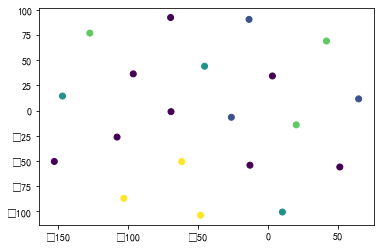

In [49]:
# 画个密度图
import matplotlib.pyplot as plt
plt.rcParams['font.family'] = ['sans-serif']
plt.rcParams['font.sans-serif'] = ['SimHei']

df_non_outliers['pca_tsne'] = data_pca_tsne.tolist()
del df_non_outliers['matrix']
data_pca_tsne = df_non_outliers['pca_tsne']
label = df_non_outliers['label']

plt.figure()
x = [i[0] for i in data_pca_tsne]
y = [i[1] for i in data_pca_tsne]
plt.scatter(x, y, c=label)
plt.show()

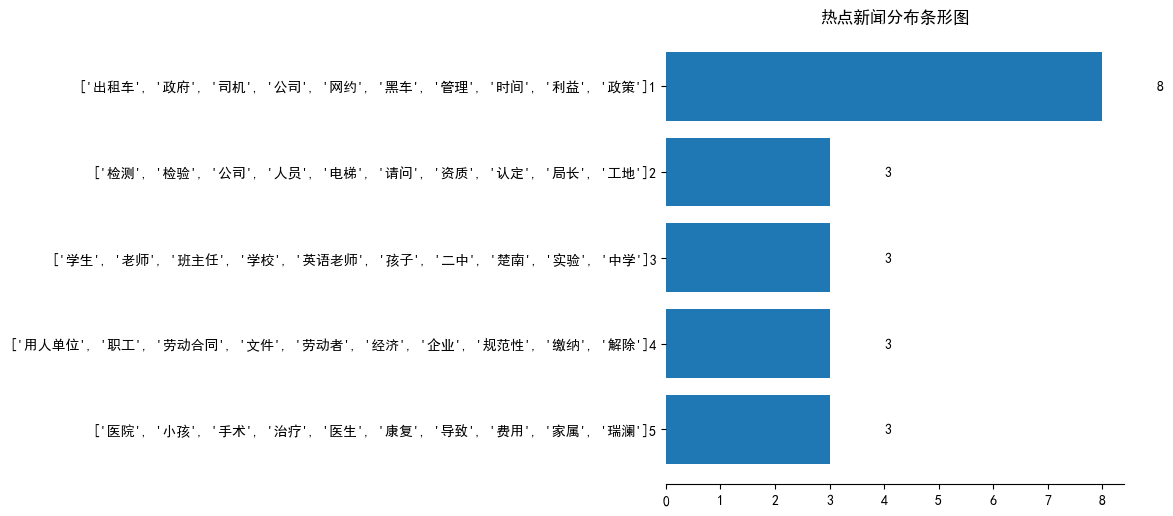

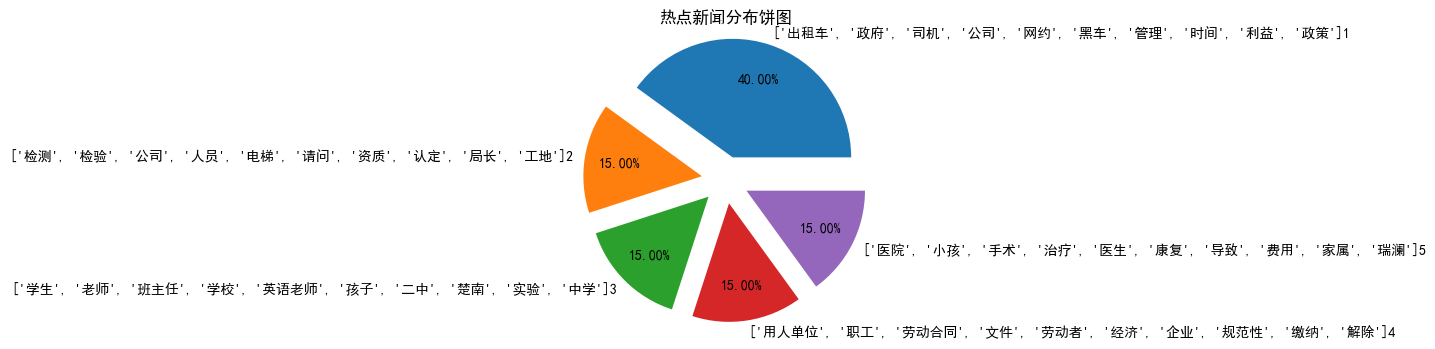

In [50]:
def draw_clustering_analysis_barh(rank_num, value, yticks, title):
    """绘制聚类分析结果条形图"""
    plt.figure(figsize=(13, 6), dpi=100)
    plt.subplot(122)
    ax = plt.gca()
    ax.spines['left'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.invert_yaxis()
    plt.barh(range(1, rank_num + 1), value, align='center', linewidth=0)
    plt.yticks(range(1, rank_num + 1), yticks)
    for a, b in zip(value, range(1, rank_num + 1)):
        plt.text(a + 1, b, '%.0f' % a, ha='left', va='center')
    plt.title(title)
    plt.savefig( '2.jpg')
    plt.show()
    
def draw_clustering_analysis_pie(rank_num, value, yticks,title):
    """绘制聚类分析结果饼图"""
    plt.figure(figsize=(13, 6), dpi=100)
    plt.subplot(132)
    plt.pie(value, explode=[0.2] * rank_num, labels=yticks, autopct='%1.2f%%', pctdistance=0.7)
    plt.title(title)
    plt.show()

    

rank_num = get_num_of_value_no_repeat(df_non_outliers['rank'])
value = [df_non_outliers[df_non_outliers['rank'] == i].shape[0] for i in range(1, rank_num + 1)]
yticks1 = [str(get_most_common_words(df_non_outliers[df_non_outliers['rank'] == i]['content_cut'],
                                             top_n=10)) + str(i) for i in range(1, rank_num + 1)]


draw_clustering_analysis_barh(rank_num, value, yticks1, title='热点新闻分布条形图')
draw_clustering_analysis_pie(rank_num, value, yticks1,title='热点新闻分布饼图')